# Generate CBED map from 4D-STEM data acquired by ELA detector with Panta Rhei

loads a sequence of diffraction frames in prz format

analyses the central brightest spot position

performs a regression of second order to the shift of the brightest spot position 

compensates the shift using the regression data

sum up the images

exports to MRC file



In [2]:
import numpy as np
#from objbrowser import browse
import matplotlib.pyplot as plt
from symfit import Poly, variables, parameters, Model, Fit

In [224]:
# Path definition and filename
# export format
path="Z:/shared/Themis/Carbon-C-Flat-231129/Carbon-C-Flat-231129/Pos2/60deg-tilt/non-filtered/"
#path="Z:/shared/Themis/ScatteringDistribution200kV-2/SiO2/Pos2/vacuum-filtered/"
#path="Z:/shared/Themis/ScatteringDistribution/carbon_support/Pos1/Vacuum-filtered/"
#path="Z:/shared/Themis/ScatteringDistribution/ice/vacuum/0deg-non-filtered/"
#path="Z:/shared/Themis/ScatteringDistribution80kV/Carbon/Vacuum-Pos1/non-filtered/"

filebasename="DataCube_0" #"DataCube_0""Survey_DF_1"
#filebasename="Survey_DF_1"
#filebasename="LiveSpectrum"
filesuffix="prz"
export="mrc"
sqcrop=False
shift_bits=0

In [225]:
# assign file handle and load object description
fn=path+filebasename+'.'+filesuffix
print("loading object descriptor: "+fn)
fh=np.load(fn, allow_pickle=True)

loading object descriptor: Z:/shared/Themis/Carbon-C-Flat-231129/Carbon-C-Flat-231129/Pos2/60deg-tilt/non-filtered/DataCube_0.prz


In [226]:
# load data array and report dimensions
print("loading data ...")
a=fh['data']
np.max(a)

loading data ...


3771

In [227]:
cnt=np.sum(a==pow(2,16)-1)
print("number of faults:", cnt)
a[a==pow(2,16)-1]=50000
print("finished")
dim=a.shape
print("array dimensions:", dim)

number of faults: 0
finished
array dimensions: (101, 101, 512, 512)


In [228]:
np.max(a)

3771

In [229]:
# load data_model and metadata
#dm=fh['data_model']
#dm
md=fh['meta_data']
md

array([{'repo_id': 'DataCube.4', 'type': 'Stack', 'ref_size': [512, 512, 672.0, 672.0], 'camera.binning': [1, 1], 'camera.pixel_size': 7.5e-05, 'camera.start_time': '2023-11-29T11:56:44.664748', 'camera.exposure_time': 0.001, 'image_size': (512, 512), 'camera.detector_size': (1028, 512), 'camera.area_offset': [258, 0], 'source.name': 'USG', 'source.type': 'scan_generator', 'source.geometry': 2, 'camera.simplon_parameters': {'roi_bit_depth': 16, 'roi_mode': 'disabled', 'nimages': 10202, 'ntrigger': 1, 'trigger_mode': 'ints', 'auto_summation': True, 'counting_mode': 'retrigger', 'incident_energy': 200000.0, 'virtual_pixel_correction_applied': True, 'countrate_correction_applied': True, 'flatfield_correction_applied': True, 'compression': 'lz4', 'pixel_mask_applied': False, 'mask_to_zero': False, 'frame_time': 0.001001, 'count_time': 0.001, 'series_id': 3102}, 'count': 10201, 'electron_gun.voltage': 200000.0, 'condenser.mode': 'UP:PROBE', 'condenser.spotsize': 6, 'scan_driver.magnificatio

frame coordinates: 34 34
frame dimensions:  (512, 512)


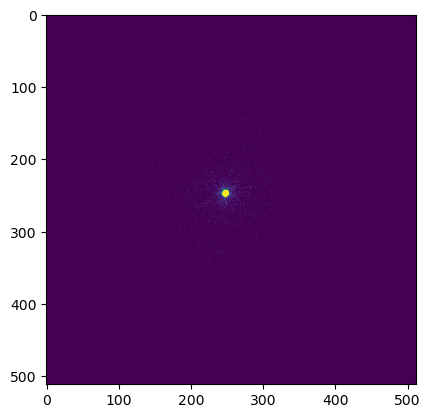

In [230]:
#show frame in 4D array
i=np.rint(dim[0]/3).astype(np.int16)
j=np.rint(dim[1]/3).astype(np.int16)
img=a[i,j,::]
print("frame coordinates:", i, j)
print("frame dimensions: ",img.shape)
plt.figure()
plt.imshow(img,vmin=0, vmax=25) 
plt.show()  # display it

In [231]:
a.dtype

dtype('uint16')

In [232]:
# crop if not square
if sqcrop:
    if (dim[3] > dim[2]):
        cx=np.rint(dim[3]/2).astype(np.uint16)
        k0=(cx-np.rint(dim[2]/2)).astype(np.uint16)
        k1=(k0+dim[2]).astype(np.uint16)
        newa=a[:,:,:,k0:k1]
        print(cx,k0,k1)
else: 
    newa=a
dim=newa.shape
print("array dimensions:", dim)

array dimensions: (101, 101, 512, 512)


In [233]:
newa.dtype

dtype('uint16')

In [234]:
# reshape array for analysis
newa=newa.reshape(dim[0]*dim[1],dim[2],dim[3]) 

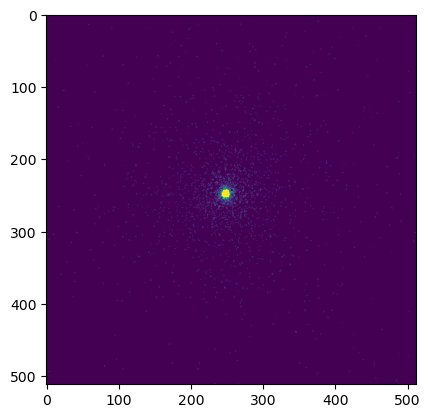

In [235]:
ind=np.rint(dim[1]*dim[0]/3).astype(np.int16)
img=newa[ind,::]
plt.figure()
plt.imshow(img,vmin=0, vmax=10) 
plt.show()  # display it

In [236]:
# dimension of 3D array
adim=newa.shape

In [237]:
np.max(newa[:,::])

3771

In [238]:
locs=np.argwhere(img==np.max(img))
loc=np.mean(locs,0)
loc

array([248., 248.])

In [239]:
# find maximum position in slice
def maxpos(data):
    adim=data.shape
    dx=np.zeros(adim[0],dtype=np.int16)
    dy=np.zeros(adim[0],dtype=np.int16)
    cx=np.floor_divide(adim[1],2)
    cy=np.floor_divide(adim[2],2)
    print("locating strongest pixel in all frames ...")
    for ind in range(data.shape[0]):
        img=data[ind,::]
        #loc=np.unravel_index(np.argmax(img, axis=None), img.shape)
        locs=np.argwhere(img==np.max(img))
        loc=np.mean(locs,0)
        dx[ind]=loc[0]-cx
        dy[ind]=loc[1]-cy
    print("finished")
    return (dx,dy)


In [240]:
# calculate dx, dy
# dx, dy are one dimensional arrays
(dx, dy) = maxpos(newa)

locating strongest pixel in all frames ...
finished


In [241]:
## Single frame analysis for strongest peak
#ind=3500
#img=newa[ind,::]
#loc=np.unravel_index(np.argmax(img, axis=None), img.shape)
#print("maximum location = ", loc)
#dx[ind]=loc[0]-cx
#dy[ind]=loc[1]-cy
#print("shift (dx, dy)= (", dx[ind],", ", dy[ind],")")
#plt.figure()
#plt.imshow(img,vmin=0, vmax=10) 
#plt.show()  # display it

In [242]:
# find maximum position in slice
def shiftbits(data):
    adim=data.shape
    print("shifting bits in all frames ...")
    for ind in range(data.shape[0]):
        data[ind,::]*=2**shift_bits
    print("finished")
    return data


In [243]:
if (shift_bits > 0):
    newa=shiftbits(newa)

In [244]:
# filter outliers
def loc_robust_against_outliers(xdata,ydata, m=2):
    boolmat=(np.logical_and((np.abs(xdata - np.mean(xdata)) < m * np.std(xdata)),(np.abs(ydata - np.mean(ydata)) < m * np.std(ydata))))
    return [np.where(boolmat),np.where(np.logical_not(boolmat))]


In [245]:
dx=dx.reshape(dim[0],dim[1])
dy=dy.reshape(dim[0],dim[1])
(robustind,rejectind)=loc_robust_against_outliers(dx,dy,4)
if robustind[1].size==0:
    print('outliers taken as norma')
    robustind=rejectind
np.shape(robustind)

(2, 10201)

In [246]:
np.std(dx)

0.41916337998789377

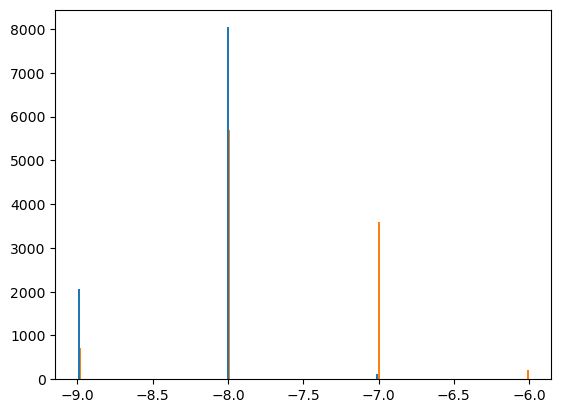

In [247]:
# plot a histogram of the locations without outliers
dxfilt=dx[robustind]
dyfilt=dy[robustind]
plt.hist([dxfilt,dyfilt],bins=100)
plt.show()

In [248]:
dyfilt

array([-9, -9, -9, ..., -7, -7, -6], dtype=int16)

In [249]:
# Print statistics without outliers
print("Displacement statistics along x, filtered for outliers (all indices):")
print("Mean = ",np.mean(dx[robustind]), "(",np.mean(dx),")")
print("Max  = ",np.max(dx[robustind]), "(",np.max(dx),")")
print("Min  = ",np.min(dx[robustind]), "(",np.min(dx),")")
print("Displacement statistics along y, filtered for outliers (all indices):")
print("Mean = ",np.mean(dy[robustind]), "(",np.mean(dy),")")
print("Max  = ",np.max(dy[robustind]), "(",np.max(dy),")")
print("Min  = ",np.min(dy[robustind]), "(",np.min(dy),")")

Displacement statistics along x, filtered for outliers (all indices):
Mean =  -8.190373492794825 ( -8.190373492794825 )
Max  =  -7 ( -7 )
Min  =  -9 ( -9 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  -7.675325948436428 ( -7.675325948436428 )
Max  =  -6 ( -6 )
Min  =  -9 ( -9 )


In [250]:
# reassign unclean data/outliers
dx[rejectind]=np.mean(dx[robustind])
dy[rejectind]=np.mean(dy[robustind])

In [251]:
# define a fit function for a polynomial fit to data 
def SurfFit2D(zdata):
    dim=zdata.shape
    x, y, z = variables('x, y, z')
    c0, c1, c2, c3, c4, c5= parameters('c0, c1, c2, c3, c4, c5')
    # Make a polynomial. Note the `as_expr` to make it symfit friendly.
    model_dict = {
        z: Poly( {(0, 0): c0, (1,0): c1, (0, 1): c2, (2, 0): c3, (0, 2): c4, (1,1): c5}, x ,y).as_expr()
    }
    model = Model(model_dict)
    print(model)

    # Generate grid data
    x_vec = np.linspace(0, 1,dim[1])
    y_vec = np.linspace(0, 1, dim[0])
    xdata, ydata = np.meshgrid(x_vec, y_vec)
    #zdata = data

    # Perform the fit
    fit = Fit(model, x=xdata, y=ydata, z=zdata)
    fit_result = fit.execute()
    zfit = model(x=xdata, y=ydata, **fit_result.params).z
    print(fit_result)
    return zfit

[z(x, y; c0, c1, c2, c3, c4, c5) = c0 + c1*x + c2*y + c3*x**2 + c4*y**2 + c5*x*y]

Parameter Value        Standard Deviation
c0        -8.886295e+00 1.755859e-02
c1        1.535860e+00 5.206521e-02
c2        5.426194e-01 5.206521e-02
c3        -6.059995e-01 4.623826e-02
c4        -6.961132e-02 4.623826e-02
c5        -4.679547e-01 4.135067e-02
Status message         Optimization terminated successfully.
Number of iterations   13
Objective              <symfit.core.objectives.LeastSquares object at 0x000001E2F57B1090>
Minimizer              <symfit.core.minimizers.BFGS object at 0x000001E2F57B2290>

Goodness of fit qualifiers:
chi_squared            1284.7925721773283
objective_value        642.3962860886642
r_squared              0.28315773702276126
Residuum statistics dx-dxfit
Mean deviation:     2.035557619269604e-15
Max abs deviation:  1.1557333397794451
Mean abs deviation: 0.2506584590863977


<Figure size 640x480 with 0 Axes>

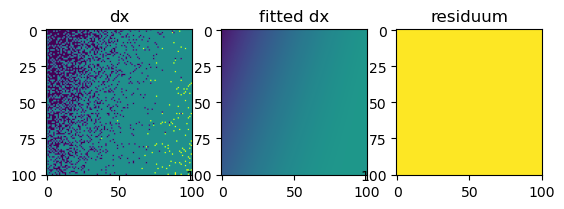

In [252]:
dx=dx.reshape(dim[0],dim[1])
dxfit=SurfFit2D(dx)
# Some residuum  statistics
print("Residuum statistics dx-dxfit")
print("Mean deviation:    ", np.mean(dx[robustind]-dxfit[robustind]))
print("Max abs deviation: ",np.max(np.abs(dx[robustind]-dxfit[robustind])))
print("Mean abs deviation:", np.mean(np.abs(dx[robustind]-dxfit[robustind])))
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 
# use the created array to output your multiple images
axarr[0].title.set_text("dx")
axarr[1].title.set_text("fitted dx")
axarr[2].title.set_text("residuum")
axarr[0].imshow(dx ,vmin=np.min(dx), vmax=np.max(dx))
axarr[1].imshow(dxfit ,vmin=np.min(dx), vmax=np.max(dx))
axarr[2].imshow(dx-dxfit ,vmin=np.min(dx), vmax=np.max(dx))
plt.show()


[z(x, y; c0, c1, c2, c3, c4, c5) = c0 + c1*x + c2*y + c3*x**2 + c4*y**2 + c5*x*y]

Parameter Value        Standard Deviation
c0        -8.562138e+00 2.323276e-02
c1        5.833350e-01 6.889043e-02
c2        8.681359e-01 6.889043e-02
c3        6.622677e-02 6.118046e-02
c4        2.273107e-01 6.118046e-02
c5        2.509666e-01 5.471342e-02
Status message         Optimization terminated successfully.
Number of iterations   13
Objective              <symfit.core.objectives.LeastSquares object at 0x000001E1B646A440>
Minimizer              <symfit.core.minimizers.BFGS object at 0x000001E1B619D9C0>

Goodness of fit qualifiers:
chi_squared            2249.342255013928
objective_value        1124.671127506964
r_squared              0.44742831455138565
Residuum statistics dx-dxfit
Mean deviation:     -2.4647843591419375e-14
Max abs deviation:  1.5478956136116437
Mean abs deviation: 0.37353101014427903


<Figure size 640x480 with 0 Axes>

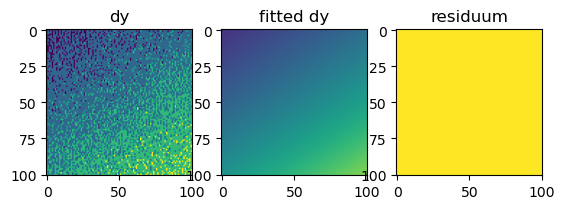

In [253]:
dy=dy.reshape(dim[0],dim[1])
dyfit=SurfFit2D(dy)
# Some residuum  statistics
print("Residuum statistics dx-dxfit")
print("Mean deviation:    ", np.mean(dy[robustind]-dyfit[robustind]))
print("Max abs deviation: ",np.max(np.abs(dy[robustind]-dyfit[robustind])))
print("Mean abs deviation:", np.mean(np.abs(dy[robustind]-dyfit[robustind])))
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 
# use the created array to output your multiple images
axarr[0].title.set_text("dy")
axarr[1].title.set_text("fitted dy")
axarr[2].title.set_text("residuum")
axarr[0].imshow(dy ,vmin=np.min(dy), vmax=np.max(dy))
axarr[1].imshow(dyfit ,vmin=np.min(dy), vmax=np.max(dy))
axarr[2].imshow(dy-dyfit ,vmin=np.min(dy), vmax=np.max(dy))
plt.show()


In [254]:
compdx=-np.rint(dxfit.reshape(dim[0]*dim[1])).astype(np.int16)
compdy=-np.rint(dyfit.reshape(dim[0]*dim[1])).astype(np.int16)

In [255]:
print("shifting frames ...")
for ind in range(newa.shape[0]):
    newa[ind,::]=np.roll(newa[ind,::],(compdy[ind],compdx[ind]),axis=(1,0))
print("finished")

shifting frames ...
finished


In [256]:
compdx

array([9, 9, 9, ..., 8, 8, 8], dtype=int16)

shift (dx, dy)= ( -8 ,  -7 )
fitted compensation (dx, dy)= ( 8 ,  8 )


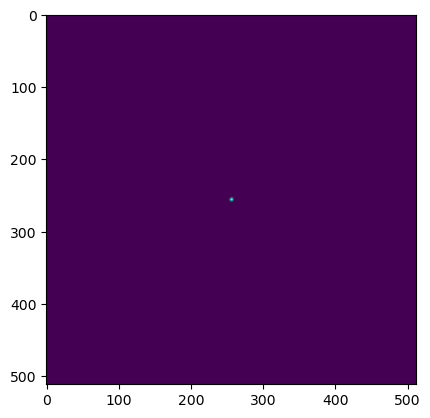

In [257]:
dx=dx.reshape(dim[0]*dim[1])
dy=dy.reshape(dim[0]*dim[1])
ind=100
img=newa[ind,::]
loc=np.unravel_index(np.argmax(img, axis=None), img.shape)
print("shift (dx, dy)= (", dx[ind],", ", dy[ind],")")
print("fitted compensation (dx, dy)= (", compdx[ind],", ", compdy[ind],")")
#img2=np.roll(newa[ind,::],(compdy[ind],compdx[ind]),axis=(1,0))
plt.figure()
plt.imshow(img) 
plt.show()  # display it

locating strongest pixel in all frames ...
finished


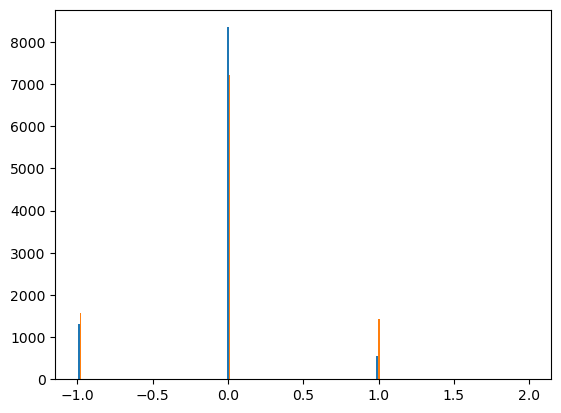

Residuum statistics (dx, dy) after regression and compensation with polynomial 2nd order 
Mean deviation:     -0.07401235173022253   -0.013233996666993432
Max abs deviation:  1   2
Mean abs deviation: 0.18204097637486522   0.2935986667973728


In [258]:
# residual shifts
(resdx, resdy) = maxpos(newa)
plt.hist([resdx,resdy],bins=100)
plt.show()
# Some residuum  statistics
print("Residuum statistics (dx, dy) after regression and compensation with polynomial 2nd order ")
print("Mean deviation:    ", np.mean(resdx), " ", np.mean(resdy))
print("Max abs deviation: ", np.max(np.abs(resdx)), " ", np.max(np.abs(resdy)))
print("Mean abs deviation:", np.mean(np.abs(resdx)), " ",np.mean(np.abs(resdy)))

In [259]:
# Dynamic range statistics
print("Dynamic range")
print("Min:    ", np.min(newa))
maxval=np.max(newa)
print("Max: ",maxval)
maxbit=np.ceil(np.log2(maxval))
print("Bit range: ", maxbit)

Dynamic range
Min:     0
Max:  3771
Bit range:  12.0


In [260]:
if (export == "raw"):
    # save as 3D binary data
    fnout=path+filebasename+'-'+str(dim[1])+'x'+str(dim[0])+'_'+str(dim[3])+'x'+str(dim[2])+'_'+str(dim[1]*dim[0])+'frames'
    if (maxbit <= 16.):
        fnout=fnout+'_uint16.raw'
        print("saving raw binary data to ",fnout)
        newa.astype('uint16').tofile(fnout)
    else:  
        fnout=fnout+'_uint32.raw'
        print("saving raw binary data to ",fnout)
        newa.astype('uint32').tofile(fnout)
    print("finished")
# load in iMtools as raw
# DimX = Dim2, DimY=Dim3, DimZ=Dim0*Dim1
# Viewing plane=xy

In [261]:
import mrcfile
?mrcfile.new

Signature: mrcfile.new(name, data=None, compression=None, overwrite=False)
Docstring:
Create a new MRC file.

Args:
    name: The file name to use, as a string or :class:`~pathlib.Path`.
    data: Data to put in the file, as a :class:`numpy array
        <numpy.ndarray>`. The default is :data:`None`, to create an empty
        file.
    compression: The compression format to use. Acceptable values are:
        :data:`None` (the default; for no compression), ``'gzip'`` or
        ``'bzip2'``.
        It's good practice to name compressed files with an appropriate
        extension (for example, ``.mrc.gz`` for gzip) but this is not
        enforced.
    overwrite: Flag to force overwriting of an existing file. If
        :data:`False` and a file of the same name already exists, the file
        is not overwritten and an exception is raised.

Returns:
    An :class:`~mrcfile.mrcfile.MrcFile` object (or a
    subclass of it if ``compression`` is specified).

Raises:
    :exc:`ValueError`:

In [262]:
newb=np.zeros([dim[2],dim[3]], dtype=np.float32)
for inda in range(0,dim[0]*dim[1]):
    newb=np.add(newb,newa[inda,:,:])

In [263]:
newb.dtype

dtype('float32')

In [264]:
newb=np.float32(newb)
newb.dtype

dtype('float32')

In [265]:
mrc=mrcfile.new(name=path+'/mean_diffraction.mrc',data=newb,overwrite=True)
mrc.set_data(newb)
mrc.close()

In [159]:
mrc

MrcFile('Z:/shared/Themis/ScatteringDistribution/carbon_support/Pos2/Vacuum-filtered-10eV//mean_diffraction.mrc', mode='w+')